In [5]:
!du -L ../jigsaw-toxic-comment-classification-challenge/*

8	../jigsaw-toxic-comment-classification-challenge/Data Exploration.ipynb
12272	../jigsaw-toxic-comment-classification-challenge/sample_submission.csv
117888	../jigsaw-toxic-comment-classification-challenge/test.csv
9728	../jigsaw-toxic-comment-classification-challenge/test_labels.csv
134384	../jigsaw-toxic-comment-classification-challenge/train.csv


In [38]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

# Data Exploration

## Check the basic info of the dataset

In [11]:
#importing the dataset
train=pd.read_csv("../jigsaw-toxic-comment-classification-challenge/train.csv")
test=pd.read_csv("../jigsaw-toxic-comment-classification-challenge/test.csv")

In [15]:
#take a peak
print(train.tail(10))
print(train.info())

                      id                                       comment_text  \
159561  ffd2e85b07b3c7e4  "\nNo he did not, read it again (I would have ...   
159562  ffd72e9766c09c97  "\n Auto guides and the motoring press are not...   
159563  ffe029a7c79dc7fe  "\nplease identify what part of BLP applies be...   
159564  ffe897e7f7182c90  Catalan independentism is the social movement ...   
159565  ffe8b9316245be30  The numbers in parentheses are the additional ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
159561      0             0        0       0       0        

In [37]:
# Check the number of each type of toxic comments
print("Total number of toxic comments:",train[train['toxic']==1].shape[0])
print("Non Toxic: ",train.toxic.value_counts()[0])
print("Toxic: ",train.toxic.value_counts()[1])
print("\n")
print("Non severe_toxic: ",train.severe_toxic.value_counts()[0])
print("severe_toxic    : ",train.severe_toxic.value_counts()[1])
print("Non obscene: ",train.obscene.value_counts()[0])
print("obscene    : ",train.obscene.value_counts()[1])
print("Non threat: ",train.threat.value_counts()[0])
print("threat    : ",train.threat.value_counts()[1])
print("Non insult: ",train.insult.value_counts()[0])
print("insult    : ",train.insult.value_counts()[1])
print("Non identity_hate: ",train.identity_hate.value_counts()[0])
print("identity_hate    : ",train.identity_hate.value_counts()[1])

Total number of toxic comments: 15294
Non Toxic:  144277
Toxic:  15294


Non severe_toxic:  157976
severe_toxic    :  1595
Non obscene:  151122
obscene    :  8449
Non threat:  159093
threat    :  478
Non insult:  151694
insult    :  7877
Non identity_hate:  158166
identity_hate    :  1405


In [43]:
#calculate the ratio of training set and test
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


## Class Imbalance

In [44]:
#caculate the ratio of clean comments
print("Tags & Numbers:")
x=train.iloc[:,2:].sum()  #make a statics of each tag of comments
print(x)
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)  #add the value from the 3st to the end columns 
train['clean']=(rowsums==0)
#count number of clean entries
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Tags & Numbers:
toxic            15294.0
severe_toxic      1595.0
obscene           8449.0
threat             478.0
insult            7877.0
identity_hate     1405.0
clean                0.0
dtype: float64
Total comments =  159571
Total clean comments =  143346
Total tags = 35098.0


Total comments - Total clean comments = 16225 < Total tags = 35098. Some comments are multi-tagged.

In [45]:
#check the missing values in training set and test set
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'clean'],
      dtype='object')
[ 15294.   1595.   8449.    478.   7877.   1405. 143346.]


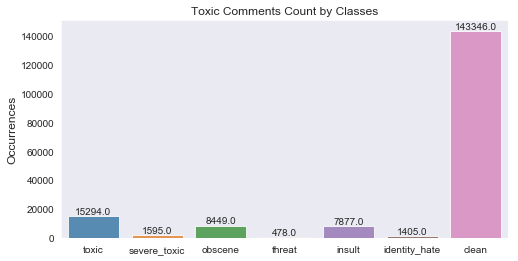

In [47]:
x=train.iloc[:,2:].sum()
print(x.index)
print(x.values)
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Toxic Comments Count by Classes")
plt.ylabel('Occurrences', fontsize=12)
# plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')  #rect.get_x() + rect.get_width()/2: write at the central

plt.show()

Conclusion:
    1. The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
    2. Some comments are multi-tagged

## Multi-tagging

0.0    143346
1.0      6360
3.0      4209
2.0      3480
4.0      1760
5.0       385
6.0        31
dtype: int64


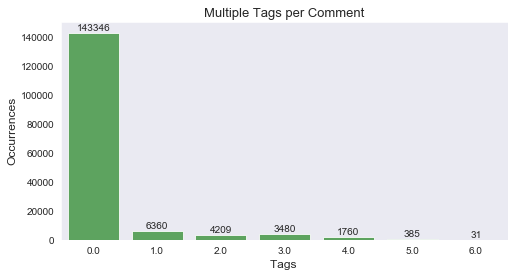

In [56]:
x=rowsums.value_counts()
print(x)

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple Tags per Comment",fontsize=13)
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Only 10.2% of the total comments have some sort of toxicity in them. There are certain comments(20) that are marked as all of the above!

### Which tags go together?

Now let's have a look at how often the tags occur together. A good indicator of that would be a correlation plot.

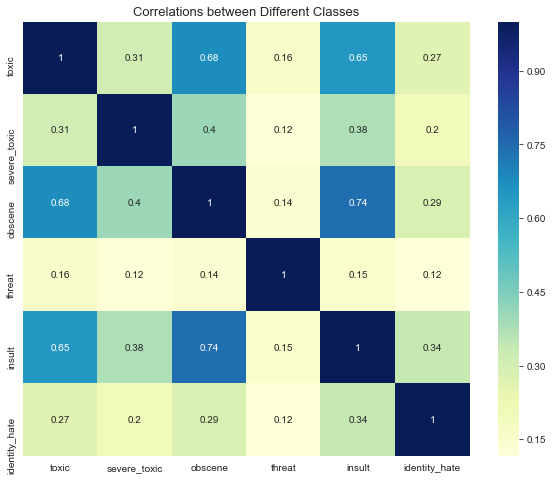

In [60]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
plt.title("Correlations between Different Classes",fontsize=13)
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True,cmap="YlGnBu")

The above plot indicates a pattern of co-occurance but Pandas's default Corr function which uses Pearson correlation does not apply here, since the variables invovled are Categorical (binary) variables.

So, to find a pattern between two categorical variables we can use other tools like

- Confusion matrix/Crosstab
- Cramer's V Statistic: an extension of the chi-square test where the extent/strength of association is also measured

In [61]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [63]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes.

Some interesting observations:

- A Severe toxic comment is always toxic
- Other classes seem to be a subset of toxic barring a few exceptions

In [64]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [65]:
# Checking for Toxic and Severe toxic for now
# Cramer's V Statistic
import pandas as pd
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.30850290540548614


### Example Comments:

In [68]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])
print("\n")
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])
print("\n")
print("Threat:")
print(train[train.threat==1].iloc[1,1])
#print(train[train.threat==1].iloc[2,1])
print("\n")
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])
#print(train[train.obscene==1].iloc[2,1])
print("\n")
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum 

That was a whole lot of toxicity. Some weird observations:
- Some of the comments are extremely and mere copy paste of the same thing
- Comments can still contain IP addresses (eg:62.158.73.165), usernames (eg:ARKJEDI10) and some mystery numbers (assume to be article-IDs), which can cause huge overfitting

## Wordclouds - Frequent words: